2 E cells with AMPA and NMDA
E-E is i!=j. All others are all to all to begin with.

The goal here is to:  
1. have a PING network with E and I.  
2. add NMDA E-E connection and see how it goes.

Try to find LTD

In 5, we only found LTP, and there was no much spike time dependence. Michelle found that it might be that the depressor in the detectors were never activated.  

09/13 change the value of phi. unit is diff in the paper.

09/18 -2 incoporate both syn-nmda and cal-nmda.

In [1]:
from brian2 import *
#import numpy as np
#import matplotlib
# import matplotlib.pyplot as plt

In [46]:
start_scope()

defaultclock.dt = 0.02*ms

Ne = 2
V_I = -80*mV
V_E = 0*mV


# some calcium-related vars, table 2
pHC = 4.0*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6
thetab = 0.55
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01
sigmab = -0.02
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

# some calcium-related vars, concentration
phi = 0.01*umolar/ms/(uamp*cm**-2)
beta = 0.083/ms
chi0 = 0.05*umolar
nbuff = 6.*umolar



# E cells stats
Cme = 1*ufarad/cm**2
Ele = -67*mV
ENae = 50*mV
EKe = -100*mV
gle = 0.1*msiemens/cm**2
gNae = 100*msiemens/cm**2
gKe = 80*msiemens/cm**2

# AMPA E-E
syn_mod = 1.

gampae = 0.05*syn_mod*msiemens/cm**2

# gampae = 0.00*syn_mod/(Ne-1)*msiemens/cm**2

#ggabae = 0.03*syn_mod/(Ni)*msiemens/cm**2


# NMDA (excitatory)
g_syn_nmda = 0.3*syn_mod*msiemens/cm**2
g_cal_nmda = 25*syn_mod*msiemens/cm**2
# g_NMDA_I = 0.258 * nS * 800. / N_E
V_cal = 140*mV
tausnmdar = 1*ms
tausnmdad = 100*ms
# Mg2 = 1.
Mg2 = 2.


eqse = '''
dv/dt = ( (gle * (Ele-v) + gNae * m**3 * h * (ENae-v) + gKe * n**4 * (EKe-v) + Isyn + I_NMDA_rec + I))/Cme : volt
Isyn = Iampa  : amp*meter**-2
Iampa = gampae * (V_E - v) * sampa_tot : amp*meter**-2
#Igaba = 0*amp*meter**-2
#Igaba = ggabae * (V_I - v) * sgaba_tot : amp*meter**-2
sampa_tot : 1
sgaba_tot: 1
#I_NMDA_rec = -g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp*meter**-2
#I_NMDA_rec = -g_NMDA_E * (v - V_calc) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp*meter**-2
I_NMDA_rec = I_cal_nmda + I_syn_nmda : amp*meter**-2
I_cal_nmda = -g_cal_nmda * (v - V_cal) / (1 + 0.3*Mg2 * exp(-0.124 * v / mV)) * s_NMDA_tot : amp*meter**-2
I_syn_nmda = -g_syn_nmda * (v - V_E) / (1 + 0.3*Mg2 * exp(-0.062 * v / mV)) * s_NMDA_tot : amp*meter**-2
s_NMDA_tot : 1
I : amp*meter**-2
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1)/ms : Hz
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)/ms : Hz
alphah = (0.128) * exp(-(v+50*mV)/(18*mV))/ms : Hz
betah = 4/(exp((-v-27*mV) / (5*mV)) + 1)/ms : Hz
alphan = (0.032/mV) * (v+52*mV) / (-exp(-(v+52*mV) / (5*mV)) + 1)/ms : Hz
betan = 0.5*exp(-(v+57*mV)/(40*mV))/ms : Hz

#chi : mmolar
#dchi/dt = phi*I_NMDA_rec/(amp*meter**-2)*mmolar/ms - beta*(chi-chi0) -(beta/nbuff)*chi**2/mmolar : mmolar
dchi/dt = phi*I_cal_nmda - beta*(chi-chi0) -(beta/nbuff)*chi**2 : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((A-thetab)/sigmab)) -B -Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((B-thetad)/sigmad)) -D)/taud : 1
'''

Ecells = NeuronGroup(Ne, eqse, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')

# Me = StateMonitor(Ecells, 'v', record=True)



# ---------------- Initialization ---------------- #
Ecells.P = 0.3
Ecells.A = 0.5
Ecells.V = 0.01
Ecells.B = 2.5
Ecells.D = 0.01

Ecells.I = linspace(0.5,0.5,(Ne))*uamp*cm**-2
Ecells.v = linspace(-65,-70,(Ne))*mV
Ecells.chi = 0.5*umolar

# ---------------- Synapses ---------------- #

tausampar = 0.2*ms
tausampad = 2*ms
tausgabar = 0.5*ms
tausgabad = 10*ms

alphaw = 0.8
betaw = 0.6
tauw = 500*ms


eqs_nmda  = ''' 
#w : 1 # synaptic weight
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
#s_NMDA_tot_post =  s_NMDA : 1 (summed)
ds_NMDA / dt = (1+tanh(v_pre/mV/10))/2 * (1-s_NMDA)/tausnmdar - s_NMDA/tausnmdad : 1 (clock-driven)
dw/dt = ( alphaw/(1+exp((P-p)/kp)) - betaw/(1+exp((D-d)/kd)) - w )/tauw :1 (clock-driven)
'''

# E-E NMDA
C_STDP_E = Synapses(Ecells, Ecells, model=eqs_nmda, 
                 method='rk4')
C_STDP_E.connect(condition='i != j')



# # E-I NMDA
# C_STDP_E = Synapses(Ecells, Ecells, model=eqs_nmda, 
#                  method='rk4')
# C_STDP.connect(condition='i != j')
# C_STDP.w[:] = 1


eqs_ampa  = ''' 
sampa_tot_post = sampa : 1 (summed)
dsampa/dt= (1+tanh(v_pre/mV/10))/2 * (1-sampa)/tausampar - sampa/tausampad : 1 (clock-driven)
w : 1 # synaptic weight
'''

eqs_gaba  = ''' 
sgaba_tot_post = sgaba : 1 (summed)
dsgaba/dt= (1+tanh(v_pre/mV/10))/2 * (1-sgaba)/tausgabar - sgaba/tausgabad : 1 (clock-driven)
w : 1 # synaptic weight
'''

# ----------------
# E-E AMPA
C_E_E_AMPA = Synapses(Ecells, Ecells, model=eqs_ampa, method='rk4')
C_E_E_AMPA.connect('i != j')

# # E-I, ampa
# C_E_I = Synapses(Ecells, Icells, model=eqs_ampa, method='rk4')
# C_E_I.connect()

# # I-I GABA
# C_I_I = Synapses(Icells, Icells, model=eqs_gaba, method='rk4')
# C_I_I.connect('i != j')


# # I-E GABA
# C_I_E = Synapses(Icells, Ecells, model=eqs_gaba, method='rk4')
# C_I_E.connect()


# Monitor
mon = StateMonitor(C_STDP_E, 'w',record = True)
mon_E = StateMonitor(Ecells, ['v','chi','P','V','A','D','B','I_NMDA_rec','I_cal_nmda','I_syn_nmda'],record = [0,1])
mon_sp = SpikeMonitor(Ecells,record = True)


## w=0.1

In [49]:


C_STDP_E.w[:] = 0.5



run(1000*ms,report='stdout')

Starting simulation at t=0.5 s for a duration of 1. s
1.0 (100%) simulated in 4s


### Plot voltage for first four cells.

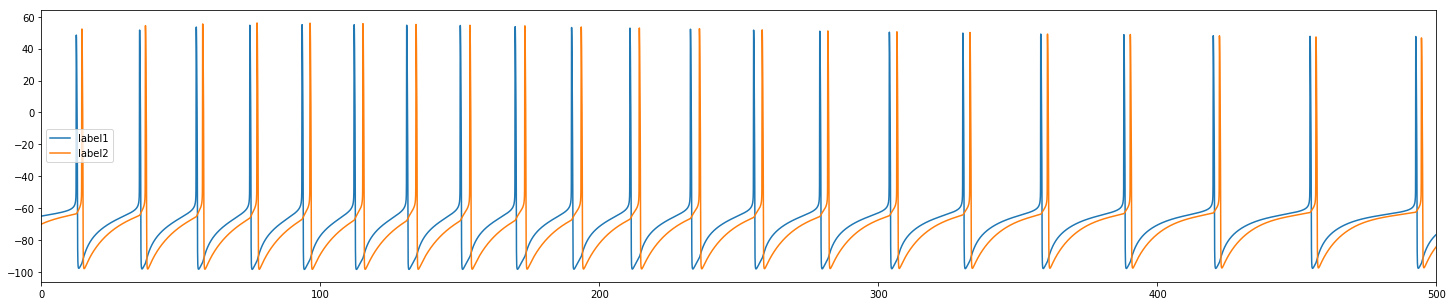

In [50]:
plt.figure(figsize=(25,5))


#plot(mon_v.t/ms,mon_v[0].v/mV)

plot(mon_E.t/ms,mon_E[0].v/mV)
plot(mon_E.t/ms,mon_E[1].v/mV)
#plot(mon_v.t/ms,mon_v[3].v/mV)

plt.xlim(00,500)
plt.legend(('label1', 'label2', 'label3','label4'))
plt.show()

(0, 1000)

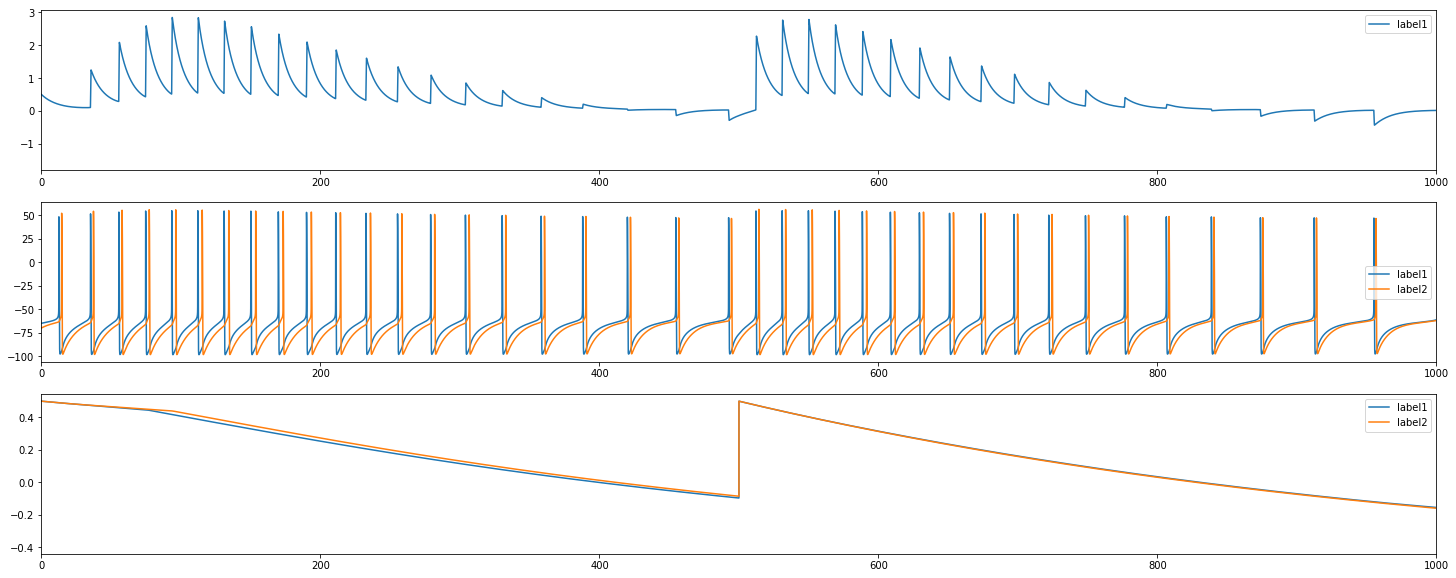

In [52]:
plt.figure(figsize=(25,10))


xlim_all = [0,1000]
subplot(3,1,1)

plot(mon_E.t/ms,mon_E[0].chi/umolar)
# plot(mon_E.t/ms,mon_E[1].chi/umolar)

# plot(mon_E.t/ms,mon_E[0].I_NMDA_rec/(uamp*cm**-2))
# plot(mon_E.t/ms,mon_E[1].I_NMDA_rec/(uamp*cm**-2))

# plot(mon_E.t/ms,mon_E[0].I_cal_nmda/(uamp*cm**-2))
# plot(mon_E.t/ms,mon_E[1].I_cal_nmda/(uamp*cm**-2))

# plot(mon_E.t/ms,mon_E[0].I_syn_nmda/(uamp*cm**-2))



# plot(mon_E.t/ms,phi*mon_E[0].I_cal_nmda)
# plot(mon_E.t/ms,phi*mon_E[1].I_cal_nmda)

# beta_soma = 0.083
# plot(mon_E.t/ms,-beta*(mon_E[0].chi-0.05*umolar))
# plot(mon_E.t/ms,-beta*(mon_E[1].chi-0.05*umolar))

# plot(mon_E.t/ms,mon_E[0].P)
# plot(mon_E.t/ms,(mon_E[0].P-0.3)*-10)
# plot(mon_E.t/ms,mon_E[1].P)
# plot(mon_E.t/ms,mon_E[0].P-mon_E[1].P)
# plot(mon_E.t/ms,1/(1+exp((mon_E[0].P-0.3)*-10)))




# plot(mon_E.t/ms,-beta/nbuff*(mon_E[0].chi)**2)

# plot(mon_E.t/ms,mon_E[0].A)
# plot(mon_E.t/ms,mon_E[1].A)
# ylim([-1,1])
# plot(mon_E.t/ms,mon_E[0].B)
# plot(mon_E.t/ms,mon_E[1].B)

# plot(mon_E.t/ms,mon_E[0].V)
# plot(mon_E.t/ms,mon_E[1].V)

# plot(mon_E.t/ms,mon_E[0].D)

# plot(mon_E.t/ms,(mon_E[0].D-0.01)*-500)
# plot(mon_E.t/ms,1/(1+exp((mon_E[0].D-0.01)*-500)))


# plot(mon_E.t/ms,mon_E[1].D)
# plot(mon_E.t/ms,mon_E[0].D-mon_E[1].D)


xlim(xlim_all)
# ylim([-1,1])
plt.legend(('label1', 'label2', 'label3','label4'))

subplot(3,1,2)
plot(mon_E.t/ms,mon_E[0].v/mV)

plot(mon_E.t/ms,mon_E[1].v/mV)
plt.legend(('label1', 'label2', 'label3','label4'))

xlim(xlim_all)


subplot(3,1,3)


# plot(mon.t/ms,mon[0].w-mon[1].w)
plot(mon.t/ms,mon[0].w)
plot(mon.t/ms,mon[1].w)

plt.legend(('label1', 'label2', 'label3','label4'))

xlim(xlim_all)
# ylim([0.33, 0.35])




In [121]:
# plot(mon_E.t/ms,phi*mon_E[0].I_NMDA_rec_)
# # plot(mon_E.t/ms,phi*mon_E[1].I_NMDA_rec/(amp*meter**-2))

# # beta_soma = 0.083
# plot(mon_E.t/ms,-beta*(mon_E[0].chi_ -0.06))
# # plot(mon_E.t/ms,-beta_soma*(mon_E[1].chi/umolar-0.06)/1e3)
# # plot(mon_E.t/ms,mon_E[0].P)
# # plot(mon_E.t/ms,mon_E[1].P)
# # plot(mon_E.t/ms,mon_E[0].P-mon_E[1].P)

# plot(mon_E.t/ms,-beta/nbuff*(mon_E[0].chi_)**2)
# mon_E[0].chi[49999]/umolar


0.24530118698566356

### Distribution of weight

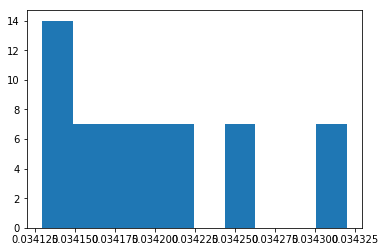

In [8]:
test_w =np.transpose(mon.w)

i = 149999
n, bins, patches = plt.hist(test_w[i][:])
plt.show()

### Plot typical change of three weight values

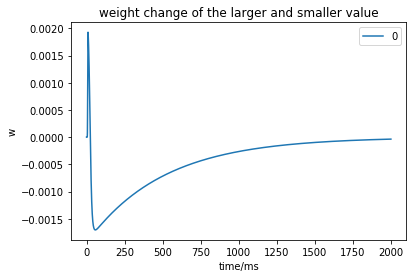

In [27]:
# plot(mon.t/ms,mon.w[7])
# plot(mon.t/ms,mon.w[0])
# plot(mon.t/ms,mon.w[1])
# plot(mon.t/ms,mon.w[2])
plot(mon.t/ms,mon.w[0] - mon.w[1])


legend(('0','1','2','3'))

# xlim(000,3000)
# ylim(0.034,0.036)
title('weight change of the larger and smaller value')
xlabel('time/ms')
ylabel('w')
plt.show()

In [98]:
C_STDP_E.i[:]
C_STDP_E.j[:]

array([1, 0], dtype=int32)

In [118]:
mon_E[0].chi[0]/umolar
# mon_E[0].I_NMDA_rec[999]
# mon_E[0].P[499999]
# plot(mon_E[0].P)

0.06

### weight 2d color plot  
code coms from pdf 5.14.8 Example: state_variables  
(i,j) element means weight from j to i.

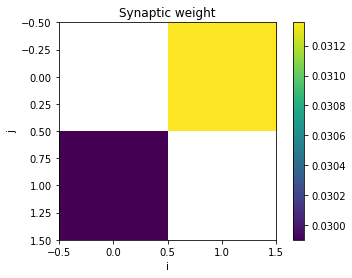

In [96]:
i=4999
test_w =np.transpose(mon.w)


w_test = np.zeros((Ne,Ne))
w_test[C_STDP_E.i[:],C_STDP_E.j[:]]=test_w[i][:]
for i_test in range(Ne):
    w_test[i_test][i_test] = nan
imshow(w_test)
colorbar()
xlabel('i')
ylabel('j')
title('Synaptic weight')
plt.show()

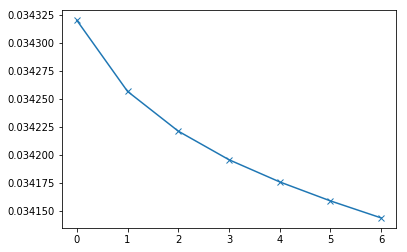

In [13]:
plot(range(Ne-1), w_test[7][0:7],'x-')

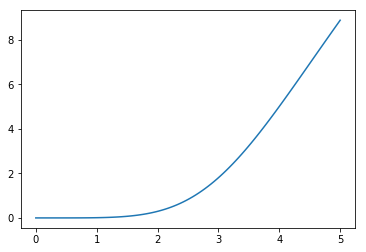

In [131]:
x_test = linspace(0,5,100)
def f(x):
    a = (10*(x/4)**5)/(1+(x/4)**4)
    return a

plot(x_test,f(x_test))


## w=0.01